<a href="https://colab.research.google.com/drive/1WWvpm-KeroqQY-suw7kyEwElVJSX8Cs4?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyOpenCL Random Walk Tutorial

----

To run the following Python code, you will need to install pyopencl and 
mako:

In [ ]:
! pip install pyopencl mako

First, let's take at our GPU specifications:

In [2]:
# print_gpu_info.py

import pyopencl as cl

def print_device_info() :
 print('\n' + '=' * 60 + '\nOpenCL Platforms and Devices')
 for platform in cl.get_platforms():
  print('=' * 60)
  print('Platform - Name: ' + platform.name)
  print('Platform - Vendor: ' + platform.vendor)
  print('Platform - Version: ' + platform.version)
  print('Platform - Profile: ' + platform.profile)
 for device in platform.get_devices():
  print(' ' + '-' * 56)
  print(' Device - Name: ' \
    + device.name)
  print(' Device - Type: ' \
    + cl.device_type.to_string(device.type))
  print(' Device - Max Clock Speed: {0} Mhz'\
    .format(device.max_clock_frequency))
  print(' Device - Compute Units: {0}'\
    .format(device.max_compute_units))
  print(' Device - Local Memory: {0:.0f} KB'\
    .format(device.local_mem_size/1024.0))
  print(' Device - Constant Memory: {0:.0f} KB'\
    .format(device.max_constant_buffer_size/1024.0))
  print(' Device - Global Memory: {0:.0f} GB'\
    .format(device.global_mem_size/1073741824.0))
  print(' Device - Max Buffer/Image Size: {0:.0f} MB'\
    .format(device.max_mem_alloc_size/1048576.0))
  print(' Device - Max Work Group Size: {0:.0f}'\
    .format(device.max_work_group_size))
  print('\n')
  
if __name__ == "__main__":
  print_device_info()


OpenCL Platforms and Devices
Platform - Name: NVIDIA CUDA
Platform - Vendor: NVIDIA Corporation
Platform - Version: OpenCL 1.2 CUDA 11.2.109
Platform - Profile: FULL_PROFILE
 --------------------------------------------------------
 Device - Name: Tesla K80
 Device - Type: ALL | GPU
 Device - Max Clock Speed: 823 Mhz
 Device - Compute Units: 13
 Device - Local Memory: 48 KB
 Device - Constant Memory: 64 KB
 Device - Global Memory: 11 GB
 Device - Max Buffer/Image Size: 2860 MB
 Device - Max Work Group Size: 1024




Now that we know what we're working with, let's run our PyOpenCL random walk code, adapted from our mpi4py implementation last week.

Simulated 10000 Random Walks in: 1.688221 seconds
Average final position: 99.995110, Standard Deviation: 9.934786


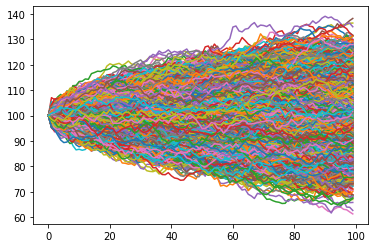

In [3]:
# gpu_rand_walk.py

import numpy as np
import pyopencl as cl
import pyopencl.array as cl_array
import pyopencl.clrandom as clrand
import pyopencl.tools as cltools
from pyopencl.scan import GenericScanKernel
import matplotlib.pyplot as plt
import time

def sim_rand_walks(n_runs):
    # Set up OpenCL context and command queue
    ctx = cl.create_some_context()
    queue = cl.CommandQueue(ctx)

    # mem_pool = cltools.MemoryPool(cltools.ImmediateAllocator(queue))

    t0 = time.time()

    # Generate an array of Normal Random Numbers on GPU of length n_sims*n_steps
    n_steps = 100
    rand_gen = clrand.PhiloxGenerator(ctx)
    ran = rand_gen.normal(queue, (n_runs*n_steps), np.float32, mu=0, sigma=1)

    # Establish boundaries for each simulated walk (i.e. start and end)
    # Necessary so that we perform scan only within rand walks and not between
    seg_boundaries = [1] + [0]*(n_steps-1)
    seg_boundaries = np.array(seg_boundaries, dtype=np.uint8)
    seg_boundary_flags = np.tile(seg_boundaries, int(n_runs))
    seg_boundary_flags = cl_array.to_device(queue, seg_boundary_flags)

    # GPU: Define Segmented Scan Kernel, scanning simulations: f(n-1) + f(n)
    prefix_sum = GenericScanKernel(ctx, np.float32,
                arguments="__global float *ary, __global char *segflags, "
                    "__global float *out",
                input_expr="ary[i]",
                scan_expr="across_seg_boundary ? b : (a+b)", neutral="0",
                is_segment_start_expr="segflags[i]",
                output_statement="out[i] = item + 100",
                options=[])

    # Allocate space for result of kernel on device
    '''
    Note: use a Memory Pool (commented out above and below) if you're invoking
    multiple times to avoid wasting time creating brand new memory areas each
    time you invoke the kernel: https://documen.tician.de/pyopencl/tools.html
    '''
    # dev_result = cl_array.arange(queue, len(ran), dtype=np.float32,
    #                                allocator=mem_pool)
    dev_result = cl_array.empty_like(ran)

    # Enqueue and Run Scan Kernel
    prefix_sum(ran, seg_boundary_flags, dev_result)

    # Get results back on CPU to plot and do final calcs, just as in Lab 1
    r_walks_all = (dev_result.get()
                         .reshape(n_runs, n_steps)
                         .transpose()
                         )

    average_finish = np.mean(r_walks_all[-1])
    std_finish = np.std(r_walks_all[-1])
    final_time = time.time()
    time_elapsed = final_time - t0

    print("Simulated %d Random Walks in: %f seconds"
                % (n_runs, time_elapsed))
    print("Average final position: %f, Standard Deviation: %f"
                % (average_finish, std_finish))

    # Plot Random Walk Paths
    '''
    Note: Scan already only starts scanning at the second entry, but for the 
    sake of the plot, let's set all of our random walk starting positions to 100
    and then plot the random walk paths.
    '''
    r_walks_all[0] = [100]*n_runs
    plt.plot(r_walks_all)
    plt.savefig("r_walk_nruns%d_gpu.png" % n_runs)

    return

def main():
    sim_rand_walks(n_runs = 10000)

if __name__ == '__main__':
    main()